# Comptage de cellules : segmentation d'images

Ce chapitre explore comment détecter, isoler et compter des cellules dans une image microscopique. Nous utiliserons des techniques de seuillage, filtrage et segmentation pour identifier chaque cellule individuellement.

---

## Concepts clés

- **Analyse des canaux RGB** : trouver le meilleur contraste
- **Seuillage et masquage** : isoler les régions d'intérêt
- **Calcul du rapport signal-sur-bruit (SNR)** : évaluer la qualité
- **Détection de pics locaux** : localiser les centres des cellules
- **Segmentation par watershed** : séparer les cellules qui se chevauchent
- **Morphologie mathématique** : nettoyer et affiner les régions

In [4]:
# Importation des bibliothèques nécessaires
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio as iio
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils import summarize_intensities

---

## Exploration des canaux RGB

Le premier pas est d'identifier quel canal offre le meilleur contraste pour distinguer les cellules du fond.

/tmp/ipykernel_2745670/3974613956.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  cell_arr = iio.imread(FILENAME)[:, :, 0:3]


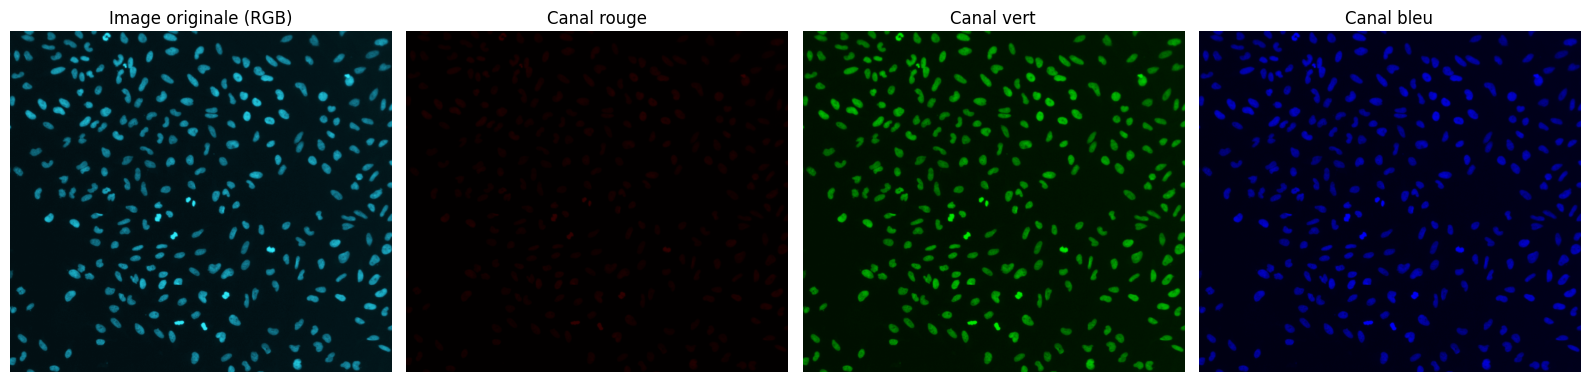

In [5]:
# Charger l'image des cellules
FILENAME = 'data/cells.png'
cell_arr = iio.imread(FILENAME)[:, :, 0:3]

# Afficher l'image originale et les trois canaux RGB
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Image originale (RGB)
im = axs[0].imshow(cell_arr)
axs[0].set_title("Image originale (RGB)")
axs[0].axis('off')

# Canal rouge uniquement
R_arr = cell_arr.copy()
R_arr[:,:,1:3] = 0
axs[1].imshow(R_arr)
axs[1].set_title("Canal rouge")
axs[1].axis('off')

# Canal vert uniquement
G_arr = cell_arr.copy()
G_arr[:,:,0:3:2] = 0
axs[2].imshow(G_arr)
axs[2].set_title("Canal vert")
axs[2].axis('off')

# Canal bleu uniquement
B_arr = cell_arr.copy()
B_arr[:,:,0:2] = 0
axs[3].imshow(B_arr)
axs[3].set_title("Canal bleu")
axs[3].axis('off')

fig.tight_layout()
plt.show()

---

## Visualisation en niveaux de gris

Convertir l'image en niveaux de gris pour faciliter le traitement. Nous pouvons utiliser la moyenne ou le maximum des canaux.

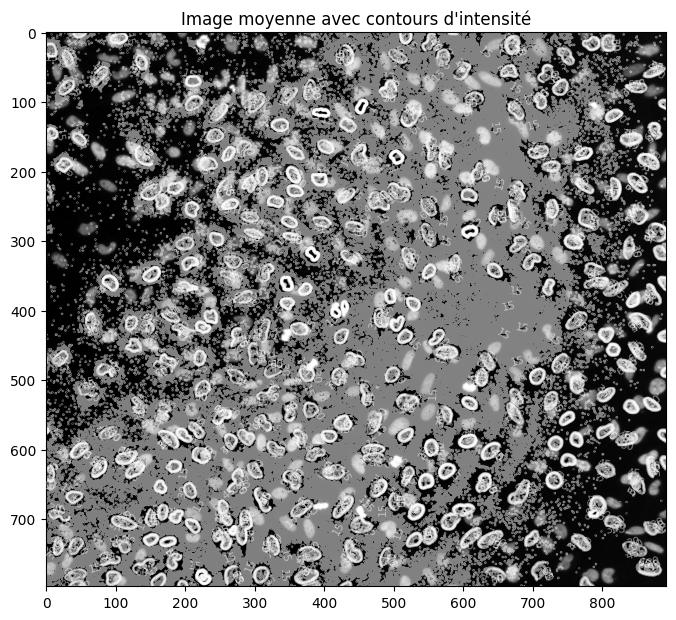

In [6]:
# Convertir en niveaux de gris en calculant la moyenne et le maximum des canaux
mean_arr = np.mean(cell_arr, axis=-1).astype(np.uint8)
max_arr = np.max(cell_arr, axis=-1).astype(np.uint8)

# Visualiser avec des contours (niveaux d'intensité)
fig, ax = plt.subplots(figsize=(8, 8))
contours = ax.contour(mean_arr, origin='image', levels=10, colors='white', alpha=0.5)
ax.clabel(contours, inline=True, fontsize=8)
ax.imshow(mean_arr, cmap='gray')
ax.set_title("Image moyenne avec contours d'intensité")
plt.show()

---

## Calcul du rapport signal-sur-bruit (SNR)

Le SNR mesure la qualité d'une image en comparant l'écart-type du signal (cellule) avec celui du bruit (fond).

**Formule** : `SNR = sqrt(std_signal / std_bruit)`

Rouge: SNR = 12.148
Vert: SNR = 4.213
Bleu: SNR = 4.221
Moyenne: SNR = 4.545
Maximum: SNR = 4.221


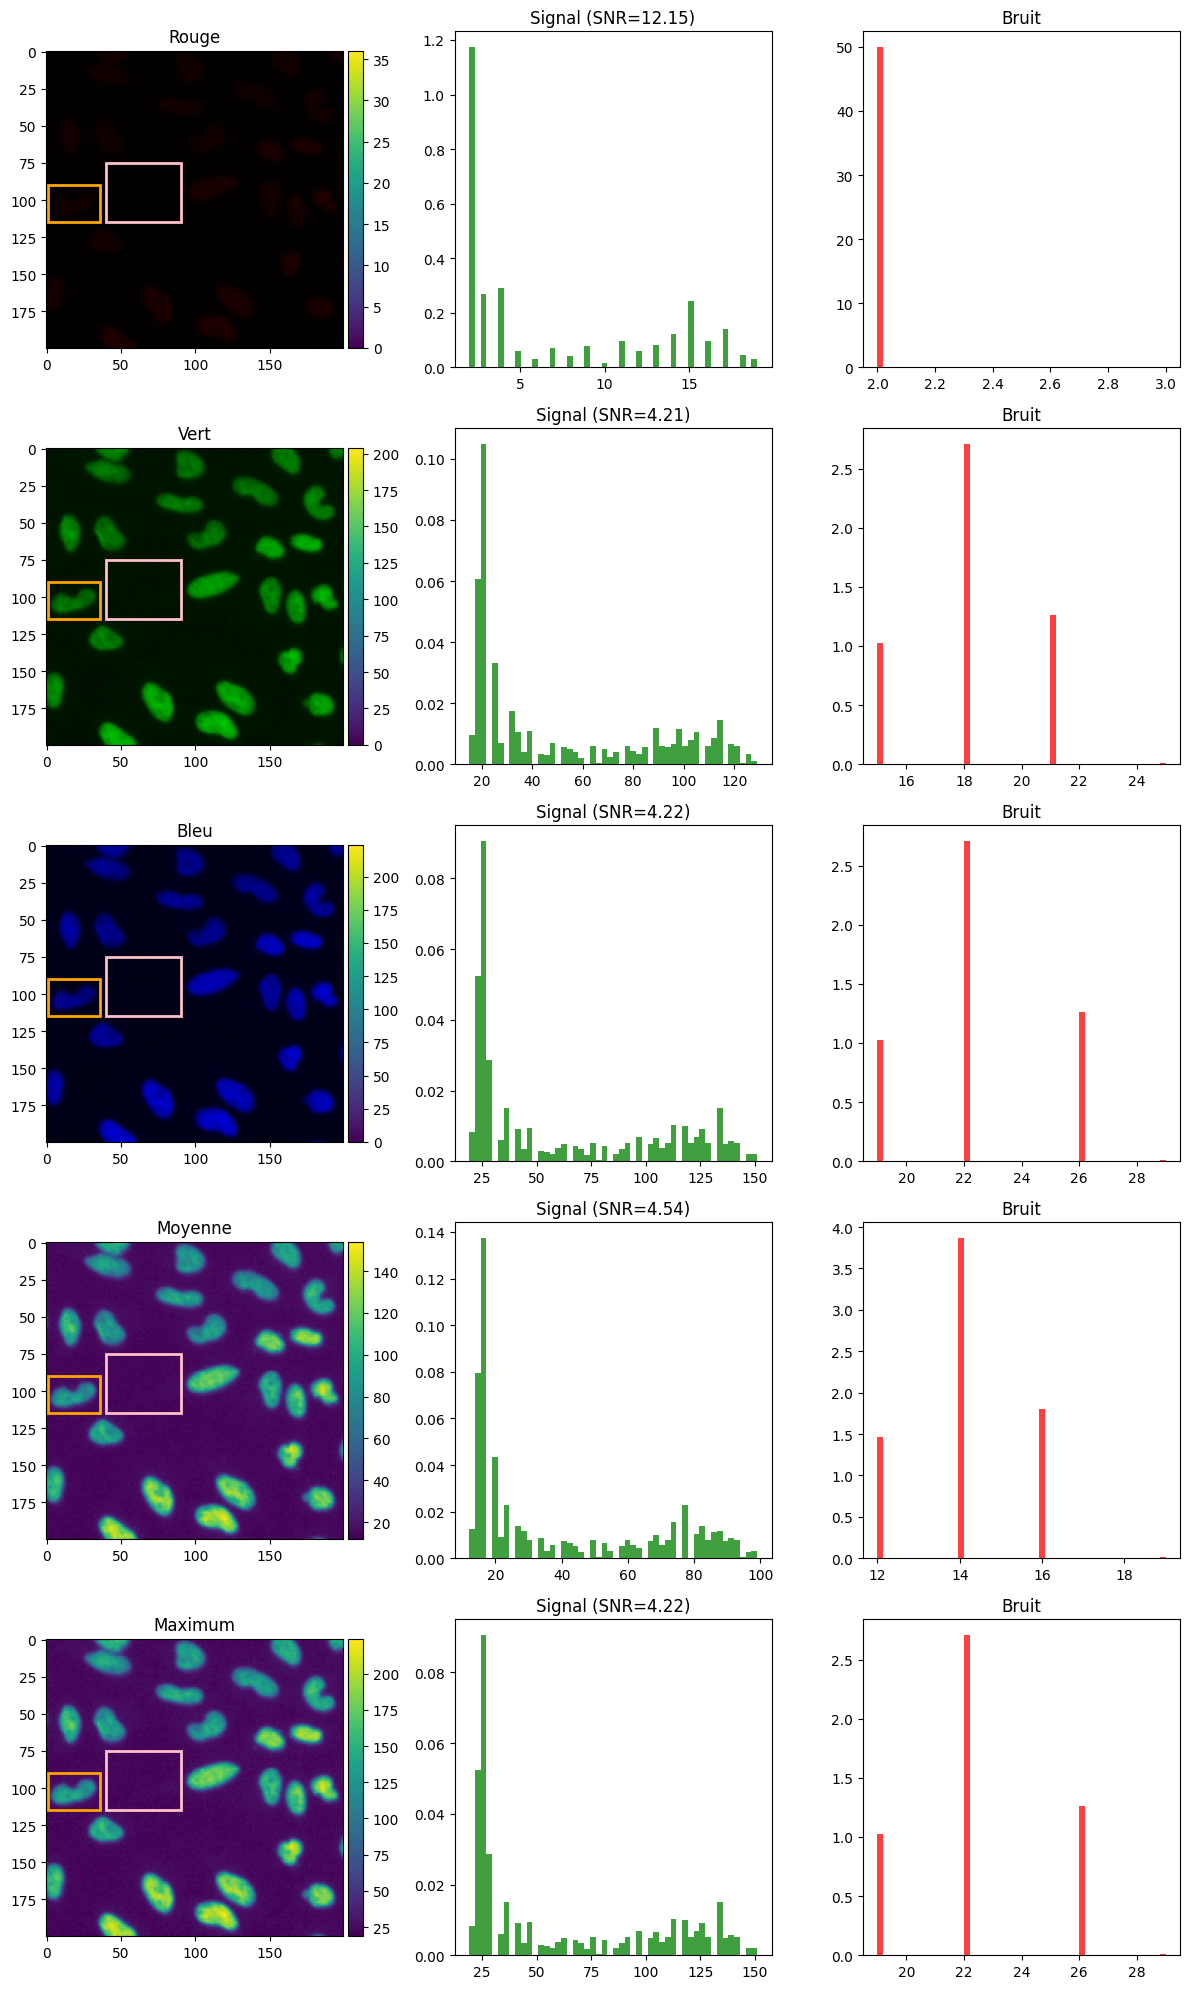

In [7]:
# Fonction pour calculer le SNR
def compute_snr_v2(data, corner_s, size_s, corner_n, size_n):
    # Extraire la région du signal (cellule)
    patch_s = data[corner_s[1]:corner_s[1]+size_s[1], corner_s[0]:corner_s[0]+size_s[0]]
    # Extraire la région du bruit (fond)
    patch_n = data[corner_n[1]:corner_n[1]+size_n[1], corner_n[0]:corner_n[0]+size_n[0]]
    
    # Calculer l'écart-type de chaque région
    std_s = np.std(patch_s)
    std_n = np.std(patch_n)
    
    # SNR = racine du ratio des écarts-type
    return np.sqrt(std_s / std_n), patch_s, patch_n

# Définir les régions pour le signal et le bruit (trouvées manuellement)
from matplotlib.patches import Rectangle

CORNER_S = (1, 90)    # Coin supérieur gauche du signal
SIZE_S = (35, 25)     # Dimensions de la région du signal
CORNER_N = (40, 75)   # Coin supérieur gauche du bruit
SIZE_N = (50, 40)     # Dimensions de la région du bruit

# Calculer et afficher le SNR pour chaque canal
titles = ['Rouge', 'Vert', 'Bleu', 'Moyenne', 'Maximum']
max_arr = np.max(cell_arr, axis=-1).astype(np.uint8)

fig, axs = plt.subplots(5, 3, figsize=(12, 20))

for i, arr in enumerate([R_arr, G_arr, B_arr, mean_arr, max_arr]):
    # Pour les deux derniers (niveaux de gris), prendre seulement une dimension
    if i > 2:
        arr_cropped = arr[0:200, 0:200]
    else:
        arr_cropped = arr[0:200, 0:200, :]
    
    # Afficher l'image originale
    im = axs[i, 0].imshow(arr_cropped)
    axs[i, 0].set_title(titles[i])
    divider = make_axes_locatable(axs[i, 0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    # Calculer le SNR
    if i > 2:
        snr, patch_s, patch_n = compute_snr_v2(arr_cropped, CORNER_S, SIZE_S, CORNER_N, SIZE_N)
    else:
        snr, patch_s, patch_n = compute_snr_v2(arr_cropped[:, :, i], CORNER_S, SIZE_S, CORNER_N, SIZE_N)
    
    # Afficher l'histogramme du signal
    axs[i, 1].hist(patch_s.ravel(), bins=50, density=True, facecolor='green', alpha=0.75)
    axs[i, 1].set_title(f"Signal (SNR={snr:.2f})")
    
    # Afficher l'histogramme du bruit
    axs[i, 2].hist(patch_n.ravel(), bins=50, density=True, facecolor='red', alpha=0.75)
    axs[i, 2].set_title("Bruit")
    
    # Marquer les régions sur l'image
    axs[i, 0].add_patch(Rectangle(CORNER_S, SIZE_S[0], SIZE_S[1],
                                  edgecolor='orange', facecolor='none', lw=2))
    axs[i, 0].add_patch(Rectangle(CORNER_N, SIZE_N[0], SIZE_N[1],
                                  edgecolor='pink', facecolor='none', lw=2))
    
    print(f"{titles[i]}: SNR = {snr:.3f}")

fig.tight_layout()
plt.show()

---

## Seuillage progressif pour isoler les cellules

Tester différents seuils pour trouver le meilleur point de rupture entre les cellules et le fond.

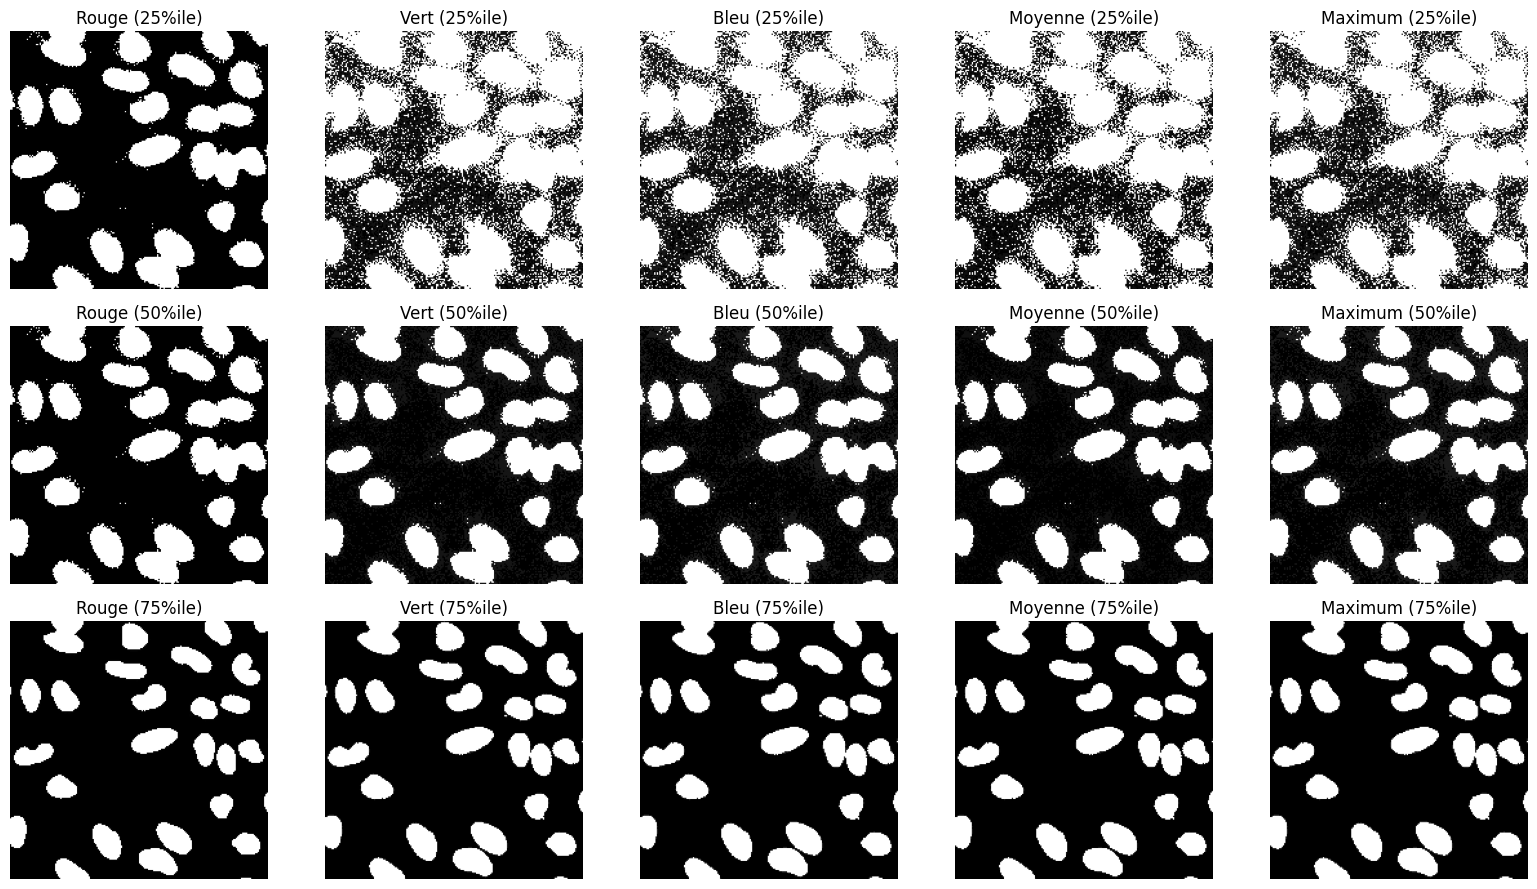

In [8]:
# Essayer différents seuils de percentiles
fig, axs = plt.subplots(3, 5, figsize=(16, 9))

for i, arr in enumerate([R_arr, G_arr, B_arr, mean_arr, max_arr]):
    # Tester trois niveaux de seuil : 25%, 50%, 75% du percentile
    for j, percentile in enumerate([25, 50, 75]):
        # Extraire seulement une région d'intérêt
        if i > 2:
            arr_cropped = arr[0:200, 0:200]
            tmp = arr_cropped.copy()
        else:
            arr_cropped = arr[0:200, 0:200, :]
            tmp = np.sum(arr_cropped, axis=-1).copy()
        
        # Appliquer le seuil : pixels au-dessus → blanc, en dessous → noir
        threshold_val = np.percentile(tmp, percentile)
        tmp[tmp > threshold_val] = 255
        tmp[tmp < threshold_val] = 0
        
        axs[j, i].imshow(tmp, cmap='gray')
        axs[j, i].set_title(f"{titles[i]} ({percentile}%ile)")
        axs[j, i].axis('off')

fig.tight_layout()
plt.show()

---

## Détection automatique de seuil par mélange gaussien

Au lieu de deviner un seuil, utiliser un **modèle de mélange gaussien (GMM)** pour identifier automatiquement les deux populations (cellules et fond).

In [9]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

# Préparer les données : extraire seulement les pixels "brillants"
cell_arr_sum = np.sum(R_arr, axis=-1).astype(float)

# Créer un masque des pixels au-dessus de la médiane
cell_mask = np.zeros(cell_arr_sum.shape)
cell_mask[cell_arr_sum > np.percentile(cell_arr_sum, 50)] = 1

# Ajuster un mélange gaussien avec 2 composantes
X = np.expand_dims(cell_arr_sum[cell_mask > 0], axis=-1)
gm = GaussianMixture(n_components=2, random_state=0).fit(X)

# Tracer l'histogramme et les gaussiennes ajustées
n, bins, patches = plt.hist(cell_arr_sum[cell_mask > 0], bins=50, density=True, 
                             facecolor='green', alpha=0.75, label='Histogramme')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)

# Première gaussienne (bruit)
mu1 = gm.means_[0, 0]
std1 = np.sqrt(gm.covariances_[0, 0, 0])
p1 = norm.pdf(x, mu1, std1)
plt.plot(x, p1, 'r-', linewidth=2, label=f'Bruit (μ={mu1:.0f})')

# Deuxième gaussienne (signal)
mu2 = gm.means_[1, 0]
std2 = np.sqrt(gm.covariances_[1, 0, 0])
p2 = norm.pdf(x, mu2, std2)
plt.plot(x, p2, 'b-', linewidth=2, label=f'Signal (μ={mu2:.0f})')

plt.xlabel("Intensité")
plt.ylabel("Densité de probabilité")
plt.title("Mélange gaussien pour segmentation automatique")
plt.legend()
plt.show()

print(f"Bruit : μ={mu1:.2f}, σ={std1:.2f}")
print(f"Signal : μ={mu2:.2f}, σ={std2:.2f}")

ModuleNotFoundError: No module named 'sklearn'

---

## Détection de pics locaux et segmentation

Utiliser la **détection de pics** pour localiser les centres des cellules, puis la **segmentation par watershed** pour séparer les cellules qui se chevauchent.

In [ ]:
from scipy.ndimage import gaussian_filter, distance_transform_edt
from sklearn.cluster import KMeans
from skimage import feature, measure, segmentation, color

# Fonction pour déterminer les pics locaux
def peak_filter(data, win_size=5, blur_sigma=5):
    """Détecter les maxima locaux dans une image."""
    # Lisser l'image pour réduire le bruit
    data_blurred = gaussian_filter(data, sigma=blur_sigma)
    
    # Obtenir les indices de tous les pixels non-zéro
    indices = np.nonzero(data)
    peak_count = 0
    new_data = np.zeros(data.shape)
    
    # Pour chaque pixel, vérifier si c'est un maximum local
    for i in range(len(indices[0])):
        x, y = indices[0][i], indices[1][i]
        
        # Définir le voisinage (avec vérification des limites)
        x_min = max(0, x - win_size)
        x_max = min(data.shape[0], x + win_size + 1)
        y_min = max(0, y - win_size)
        y_max = min(data.shape[1], y + win_size + 1)
        
        # Extraire le voisinage et vérifier si le pixel courant est le maximum
        neighborhood = data_blurred[x_min:x_max, y_min:y_max]
        if data_blurred[x, y] == np.max(neighborhood):
            peak_count += 1
            new_data[x, y] = peak_count
    
    print(f"Nombre de pics détectés : {peak_count}")
    return new_data

# Appliquer le seuillage automatique basé sur le GMM
threshold = mu1 - 1 * std1
cell_arr_thresh = cell_arr_sum.copy()
cell_arr_thresh[cell_arr_thresh < threshold] = 0
cell_arr_thresh[cell_arr_thresh >= threshold] = 1

# Détecter les pics
peaks = peak_filter(cell_arr_thresh, win_size=5, blur_sigma=5)

# Segmentation par watershed
distance = distance_transform_edt(cell_arr_thresh.astype(bool))
local_maxima = feature.peak_local_max(distance, min_distance=7)
local_max_mask = np.zeros(distance.shape, dtype=bool)
local_max_mask[tuple(local_maxima.T)] = True
markers = measure.label(local_max_mask)
segmented = segmentation.watershed(-distance, markers, mask=cell_arr_thresh.astype(bool))

# Afficher les résultats
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

ax[0].imshow(cell_arr_thresh, cmap='gray')
ax[0].set_title("Masque binaire (cellules)")
ax[0].axis('off')

ax[1].imshow(color.label2rgb(segmented, bg_label=0))
ax[1].set_title(f"Segmentation (n={len(np.unique(segmented))-1} cellules)")
ax[1].axis('off')

# Superposition
ax[2].imshow(color.label2rgb(segmented, mean_arr, alpha=0.4, bg_label=0))
ax[2].set_title("Overlay sur image originale")
ax[2].axis('off')

fig.tight_layout()
plt.show()

---

## Nettoyage des régions segmentées

Appliquer des opérations morphologiques pour remplir les trous et améliorer la segmentation.

In [ ]:
from scipy.ndimage import binary_closing, binary_opening

def clean_up_labels(labeled_image):
    """Nettoyer les étiquettes en remplissant les trous à l'intérieur des cellules."""
    new_data = np.zeros(labeled_image.shape)
    
    # Pour chaque région étiqu étée
    for label_idx in np.unique(labeled_image)[1:]:
        # Créer une image binaire pour cette région
        tmp = np.zeros(labeled_image.shape)
        tmp[labeled_image == label_idx] = 1
        
        # Appliquer fermeture morphologique pour remplir les trous
        tmp = binary_closing(tmp, iterations=3)
        
        # Réassigner l'étiquette
        new_data[tmp > 0] = label_idx
    
    return new_data

# Nettoyer la segmentation
cleaned_segmented = clean_up_labels(segmented)

# Afficher avant et après nettoyage
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

ax[0].imshow(mean_arr, cmap='gray')
ax[0].set_title("Image originale")
ax[0].axis('off')

ax[1].imshow(color.label2rgb(segmented, bg_label=0))
ax[1].set_title(f"Avant nettoyage ({len(np.unique(segmented))-1} cellules)")
ax[1].axis('off')

ax[2].imshow(color.label2rgb(cleaned_segmented, bg_label=0))
ax[2].set_title(f"Après nettoyage ({len(np.unique(cleaned_segmented))-1} cellules)")
ax[2].axis('off')

fig.tight_layout()
plt.show()

print(f"Cellules détectées : {len(np.unique(cleaned_segmented)) - 1}")

---

## Résumé

- **Exploration des canaux** : identifier le meilleur contraste
- **SNR** : évaluer la qualité signal/bruit
- **Seuillage** : isoler les cellules du fond
- **Mélange gaussien** : détection automatique du seuil
- **Watershed** : segmenter les cellules qui se chevauchent
- **Morphologie mathématique** : nettoyer et affiner les régions

Prochain chapitre : `i_registration_overlap.ipynb`